In [25]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Фиксируем seed для воспроизводимости
np.random.seed(123)

## Загрузка данных

Читаем тренировочный и тестовый датасеты.
Целевая переменная теперь: LoanApproved

In [26]:
input_train = pd.read_csv('data/train_c.csv')
input_test = pd.read_csv('data/test_c.csv')

print(f"Размер train: {input_train.shape}")
print(f"Размер test: {input_test.shape}")
input_train.head()

Размер train: (11017, 35)
Размер test: (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


## Очистка данных

Удаляем пропуски в целевой переменной и дубликаты.

In [27]:
# Удаляем строки с пропусками в LoanApproved
input_train = input_train.dropna(subset=['LoanApproved'])

# Удаляем дубликаты
input_train = input_train.drop_duplicates()

print(f"Размер после очистки: {input_train.shape}")

Размер после очистки: (10000, 35)


## Распределение целевой переменной

Посмотрим на баланс классов LoanApproved.

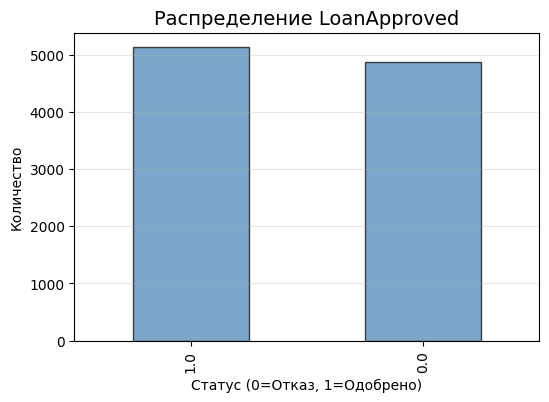

In [28]:
plt.figure(figsize=(6, 4))
input_train['LoanApproved'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Распределение LoanApproved', fontsize=14)
plt.xlabel('Статус (0=Отказ, 1=Одобрено)')
plt.ylabel('Количество')
plt.grid(axis='y', alpha=0.3)
plt.show()

## Подготовка признаков

Выделяем целевую переменную и формируем матрицы признаков.

In [29]:
# Целевая переменная
response_var = input_train['LoanApproved'].copy()

# Убираем ненужные колонки
input_features_train = input_train.drop(['ApplicationDate', 'LoanApproved'], axis=1, errors='ignore')
input_features_test = input_test.drop(['ID', 'ApplicationDate'], axis=1, errors='ignore')

print(f"Признаков в train: {input_features_train.shape[1]}")
print(f"Признаков в test: {input_features_test.shape[1]}")

Признаков в train: 33
Признаков в test: 33


## Обработка категориальных переменных

Применяем one-hot encoding к категориальным признакам.

In [30]:
# Находим категориальные переменные
cat_vars = input_features_train.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальных переменных: {len(cat_vars)}")

if cat_vars:
    # One-hot encoding
    input_features_train = pd.get_dummies(input_features_train, columns=cat_vars, drop_first=True)
    input_features_test = pd.get_dummies(input_features_test, columns=cat_vars, drop_first=True)
    
    # Выравниваем колонки между train и test
    cols_only_train = set(input_features_train.columns) - set(input_features_test.columns)
    for col_name in cols_only_train:
        input_features_test[col_name] = 0
    cols_only_test = set(input_features_test.columns) - set(input_features_train.columns)
    input_features_test.drop(columns=cols_only_test, inplace=True)
    
    input_features_test = input_features_test[input_features_train.columns]

print(f"Признаков после encoding: {input_features_train.shape[1]}")

Категориальных переменных: 5
Признаков после encoding: 44


## Импьютация и клиппинг выбросов

Заполняем пропуски медианой и обрезаем выбросы по 2-98 перцентилям.

In [31]:
for var in input_features_train.columns:
    # Заполняем пропуски медианой
    if input_features_train[var].isna().any():
        med_fill = input_features_train[var].median()
        input_features_train[var] = input_features_train[var].fillna(med_fill)
        input_features_test[var] = input_features_test[var].fillna(med_fill)
    
    # Клиппинг выбросов для числовых признаков
    if input_features_train[var].dtype in ['float64', 'int64']:
        p_min = input_features_train[var].quantile(0.02)
        p_max = input_features_train[var].quantile(0.98)
        input_features_train[var] = input_features_train[var].clip(p_min, p_max)
        input_features_test[var] = input_features_test[var].clip(p_min, p_max)

print("Импьютация и клиппинг завершены!")

Импьютация и клиппинг завершены!


## Feature Engineering

Создаём новые признаки. Ранжируем по корреляции с LoanApproved.

In [32]:
# Хранилище для новых признаков
additions_train = []
additions_test = []
add_names = []

# Ранжируем признаки по корреляции с целевой переменной
var_corrs = {var: abs(input_features_train[var].corr(response_var)) for var in input_features_train.columns}
sorted_vars = sorted(var_corrs.items(), key=lambda kv: kv[1], reverse=True)

# Выбираем топ признаков для разных преобразований
top20 = [v for v, _ in sorted_vars[:20]]
top15 = [v for v, _ in sorted_vars[:15]]
top12 = [v for v, _ in sorted_vars[:12]]
top10 = [v for v, _ in sorted_vars[:10]]
top5 = [v for v, _ in sorted_vars[:5]]
top4 = [v for v, _ in sorted_vars[:4]]

print(f"Топ-5 признаков по корреляции: {top5}")

Топ-5 признаков по корреляции: ['MonthlyIncome', 'AnnualIncome', 'InterestRate', 'BaseInterestRate', 'TotalDebtToIncomeRatio']


### Полиномиальные признаки

Создаём квадраты, кубы и 4-е степени для топовых признаков.

In [33]:
# Квадраты для топ-20
for v in top20:
    additions_train.append(input_features_train[v] ** 2)
    additions_test.append(input_features_test[v] ** 2)
    add_names.append(f'{v}_sqr')

# Кубы для топ-15
for v in top15:
    additions_train.append(input_features_train[v] ** 3)
    additions_test.append(input_features_test[v] ** 3)
    add_names.append(f'{v}_cube')

# 4-я степень для топ-4
for v in top4:
    additions_train.append(input_features_train[v] ** 4)
    additions_test.append(input_features_test[v] ** 4)
    add_names.append(f'{v}_pow4')

print(f"Добавлено полиномиальных признаков: {len(add_names)}")

Добавлено полиномиальных признаков: 39


### Взаимодействия признаков

Создаём попарные и тройные произведения топовых признаков.

In [34]:
# Попарные произведения для топ-12
for idx1 in range(len(top12)):
    for idx2 in range(idx1 + 1, len(top12)):
        v1, v2 = top12[idx1], top12[idx2]
        additions_train.append(input_features_train[v1] * input_features_train[v2])
        additions_test.append(input_features_test[v1] * input_features_test[v2])
        add_names.append(f'{v1}_mul_{v2}')

# Тройные произведения для топ-4
for i in range(len(top4)):
    for j in range(i+1, len(top4)):
        for k in range(j+1, len(top4)):
            v1, v2, v3 = top4[i], top4[j], top4[k]
            additions_train.append(input_features_train[v1] * input_features_train[v2] * input_features_train[v3])
            additions_test.append(input_features_test[v1] * input_features_test[v2] * input_features_test[v3])
            add_names.append(f'{v1}_mul_{v2}_mul_{v3}')

print(f"Всего признаков после взаимодействий: {len(add_names)}")

Всего признаков после взаимодействий: 109


### Логарифмические и корневые преобразования

In [35]:
# Логарифм для финансовых признаков
key_finance = ['AnnualIncome', 'MonthlyIncome', 'LoanAmount', 'TotalAssets', 'NetWorth',
               'CreditScore', 'SavingsAccountBalance', 'CheckingAccountBalance']
for v in key_finance:
    if v in input_features_train.columns:
        additions_train.append(np.log1p(np.maximum(input_features_train[v], 0)))
        additions_test.append(np.log1p(np.maximum(input_features_test[v], 0)))
        add_names.append(f'{v}_ln')

# Квадратный корень для топ-15
for v in top15:
    additions_train.append(np.sqrt(np.abs(input_features_train[v])))
    additions_test.append(np.sqrt(np.abs(input_features_test[v])))
    add_names.append(f'{v}_sqrt')

# Обратные значения для топ-5
for v in top5:
    additions_train.append(1 / (np.abs(input_features_train[v]) + 1))
    additions_test.append(1 / (np.abs(input_features_test[v]) + 1))
    add_names.append(f'{v}_inv')

print(f"Всего признаков после преобразований: {len(add_names)}")

Всего признаков после преобразований: 137


### Финансовые соотношения

In [36]:
# Соотношение годового и месячного дохода
if 'AnnualIncome' in input_features_train.columns and 'MonthlyIncome' in input_features_train.columns:
    additions_train.append(input_features_train['AnnualIncome'] / (input_features_train['MonthlyIncome'] * 12 + 1))
    additions_test.append(input_features_test['AnnualIncome'] / (input_features_test['MonthlyIncome'] * 12 + 1))
    add_names.append('inc_consist')

# Кредитный скор относительно возраста
if 'CreditScore' in input_features_train.columns and 'Age' in input_features_train.columns:
    additions_train.append(input_features_train['CreditScore'] / (input_features_train['Age'] + 1))
    additions_test.append(input_features_test['CreditScore'] / (input_features_test['Age'] + 1))
    add_names.append('cred_age')

# Сумма кредита относительно дохода
if 'LoanAmount' in input_features_train.columns and 'AnnualIncome' in input_features_train.columns:
    additions_train.append(input_features_train['LoanAmount'] / (input_features_train['AnnualIncome'] + 1))
    additions_test.append(input_features_test['LoanAmount'] / (input_features_test['AnnualIncome'] + 1))
    add_names.append('loan_inc')

# Сумма кредита относительно чистой стоимости
if 'LoanAmount' in input_features_train.columns and 'NetWorth' in input_features_train.columns:
    additions_train.append(input_features_train['LoanAmount'] / (input_features_train['NetWorth'] + 1))
    additions_test.append(input_features_test['LoanAmount'] / (input_features_test['NetWorth'] + 1))
    add_names.append('loan_net')

# Соотношение долгов к активам
if 'TotalLiabilities' in input_features_train.columns and 'TotalAssets' in input_features_train.columns:
    additions_train.append(input_features_train['TotalLiabilities'] / (input_features_train['TotalAssets'] + 1))
    additions_test.append(input_features_test['TotalLiabilities'] / (input_features_test['TotalAssets'] + 1))
    add_names.append('debt_asset')

# Сбережения относительно месячного дохода
if 'SavingsAccountBalance' in input_features_train.columns and 'MonthlyIncome' in input_features_train.columns:
    additions_train.append(input_features_train['SavingsAccountBalance'] / (input_features_train['MonthlyIncome'] + 1))
    additions_test.append(input_features_test['SavingsAccountBalance'] / (input_features_test['MonthlyIncome'] + 1))
    add_names.append('savings_inc')

print(f"Добавлено финансовых соотношений")

Добавлено финансовых соотношений


### Бинаризация возраста

Разбиваем возраст на категории: молодые, средний возраст, пожилые.

In [37]:
bins = [0, 30, 50, 100]
labels = [0, 1, 2]  # 0=молодые, 1=средний возраст, 2=пожилые
age_binned_train = pd.cut(input_features_train['Age'], bins=bins, labels=labels, ordered=True)
age_binned_test = pd.cut(input_features_test['Age'], bins=bins, labels=labels, ordered=True)
additions_train.append(pd.Series(age_binned_train).astype(float))
additions_test.append(pd.Series(age_binned_test).astype(float))
add_names.append('age_binned')

print(f"Итого новых признаков: {len(add_names)}")

Итого новых признаков: 144


## Объединение всех признаков

In [38]:
# Собираем все новые признаки в DataFrame
add_df_train = pd.concat([pd.Series(data, name=n) for data, n in zip(additions_train, add_names)], axis=1)
add_df_test = pd.concat([pd.Series(data, name=n) for data, n in zip(additions_test, add_names)], axis=1)

# Объединяем с исходными признаками
input_features_train = pd.concat([input_features_train.reset_index(drop=True), add_df_train.reset_index(drop=True)], axis=1)
input_features_test = pd.concat([input_features_test.reset_index(drop=True), add_df_test.reset_index(drop=True)], axis=1)

print(f"Итоговое количество признаков: {input_features_train.shape[1]}")

Итоговое количество признаков: 188


## Обработка бесконечных значений и пропусков

In [39]:
# Заменяем бесконечности на NaN
input_features_train = input_features_train.replace([np.inf, -np.inf], np.nan)
input_features_test = input_features_test.replace([np.inf, -np.inf], np.nan)

# Заполняем пропуски медианой
for var in input_features_train.columns:
    if input_features_train[var].isna().sum() > 0:
        med_val = input_features_train[var].median()
        fill_val = 0 if np.isnan(med_val) else med_val
        input_features_train[var].fillna(fill_val, inplace=True)
        input_features_test[var].fillna(fill_val, inplace=True)

print("Обработка пропусков завершена!")

Обработка пропусков завершена!


## Удаление мультиколлинеарных признаков

Удаляем признаки с корреляцией выше 0.995 между собой.

In [40]:
corr_table = input_features_train.corr()
remove_set = set()

for row in range(corr_table.shape[0]):
    for col in range(row + 1, corr_table.shape[1]):
        if abs(corr_table.iloc[row, col]) > 0.995:
            var1, var2 = corr_table.columns[row], corr_table.columns[col]
            corr1 = abs(input_features_train[var1].corr(response_var))
            corr2 = abs(input_features_train[var2].corr(response_var))
            # Удаляем признак с меньшей корреляцией с таргетом
            remove_set.add(var2 if corr1 > corr2 else var1)

if remove_set:
    print(f"Удаляем {len(remove_set)} мультиколлинеарных признаков")
    input_features_train.drop(columns=remove_set, inplace=True)
    input_features_test.drop(columns=remove_set, inplace=True)

print(f"Признаков после удаления: {input_features_train.shape[1]}")

Удаляем 38 мультиколлинеарных признаков
Признаков после удаления: 150


## Стандартизация признаков

In [41]:
scaler_obj = StandardScaler()
input_features_train_scaled = scaler_obj.fit_transform(input_features_train)
input_features_test_scaled = scaler_obj.transform(input_features_test)

print("Стандартизация завершена!")

Стандартизация завершена!


## Разделение на train/validation

In [42]:
train_feats, val_feats, train_resp, val_resp = train_test_split(
    input_features_train_scaled, response_var, test_size=0.2, random_state=123, stratify=response_var
)

print(f"Train: {train_feats.shape}")
print(f"Validation: {val_feats.shape}")

Train: (8000, 150)
Validation: (2000, 150)


## Оптимизация гиперпараметров (GridSearch)

Используем LogisticRegression, так как это линейная модель для классификации.
Подбираем параметр регуляризации C и тип штрафа.

In [43]:
# Определяем модель
log_reg = LogisticRegression(solver='liblinear', random_state=123)

# Сетка параметров
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# GridSearch
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(train_feats, train_resp)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

# Лучшая модель
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'C': 0.1, 'penalty': 'l1'}
Лучший ROC-AUC на кросс-валидации: 0.9851


## Оценка качества на валидации

Метрики: ROC-AUC, Precision, Recall, F1.

In [44]:
# Предсказание вероятностей (для ROC-AUC)
val_probs = best_model.predict_proba(val_feats)[:, 1]
# Предсказание классов (для метрик классификации)
val_preds = best_model.predict(val_feats)

roc_auc = roc_auc_score(val_resp, val_probs)
prec = precision_score(val_resp, val_preds)
rec = recall_score(val_resp, val_preds)
f1 = f1_score(val_resp, val_preds)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

ROC-AUC: 0.9839
Precision: 0.9227
Recall: 0.9317
F1-score: 0.9272


### Матрица ошибок (Confusion Matrix)

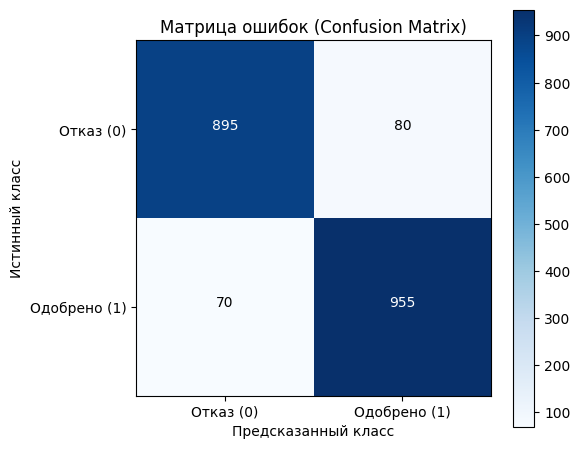

In [45]:
conf_matrix = confusion_matrix(val_resp, val_preds)

plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Матрица ошибок (Confusion Matrix)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Отказ (0)', 'Одобрено (1)'])
plt.yticks(tick_marks, ['Отказ (0)', 'Одобрено (1)'])

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

### Визуализация ROC-кривой и PR-кривой

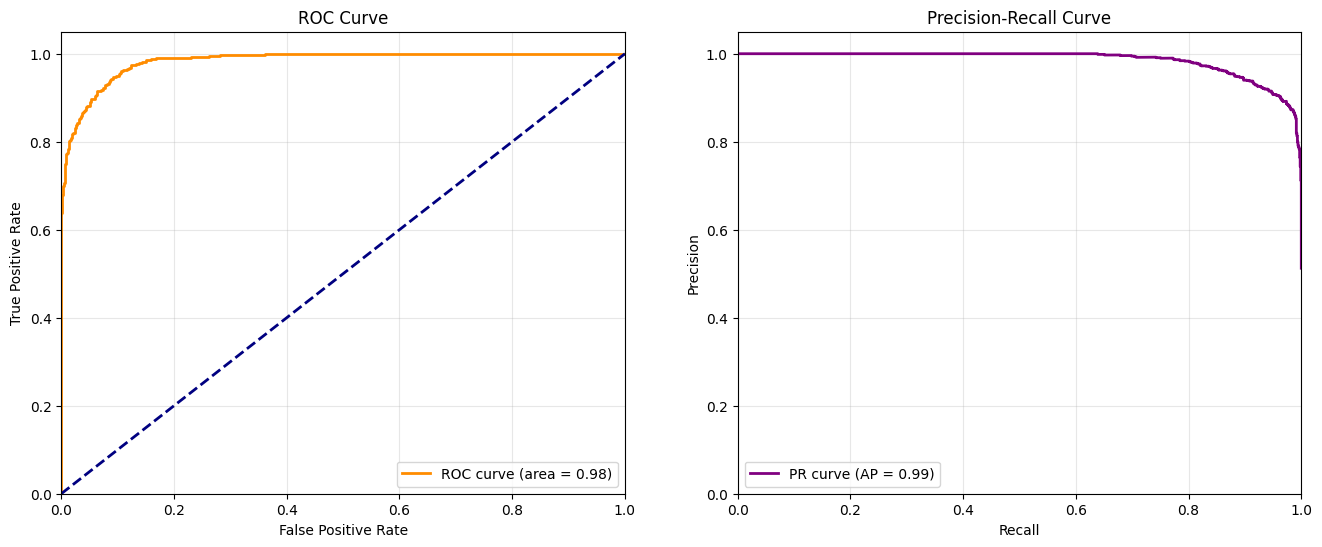

In [46]:
fpr, tpr, thresholds = roc_curve(val_resp, val_probs)
roc_auc_val = auc(fpr, tpr)

# PR-кривая
precision, recall, _ = precision_recall_curve(val_resp, val_probs)
pr_auc_val = average_precision_score(val_resp, val_probs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# PR
ax2.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {pr_auc_val:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")
ax2.grid(alpha=0.3)

plt.show()

### Важность признаков (Feature Importance)

Анализируем веса (коэффициенты) модели Logistic Regression.

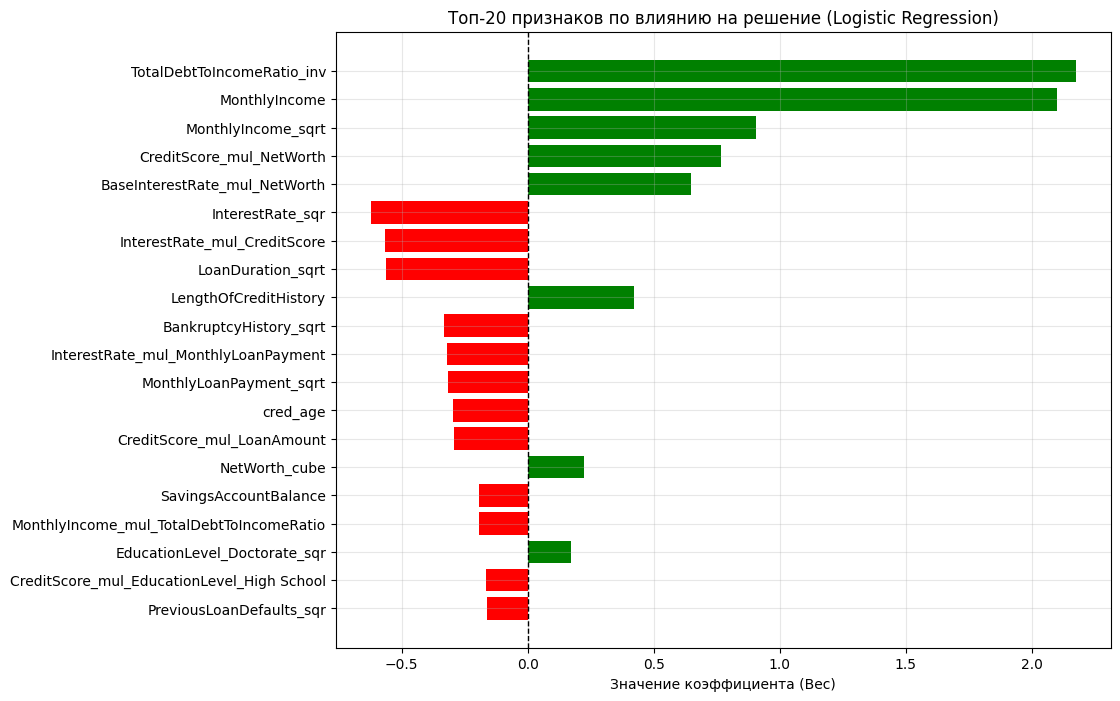

In [47]:
feature_names = input_features_train.columns
coefficients = best_model.coef_[0]

# Создаем DataFrame для удобства
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)

plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.xlabel('Значение коэффициента (Вес)')
plt.title('Топ-20 признаков по влиянию на решение (Logistic Regression)')
plt.axvline(x=0, color='black', linestyle='--', lw=1)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

## Финальное обучение и предсказание на тесте

Обучаем лучшую модель на всех данных.

In [48]:
# Переобучаем на всех данных с лучшими параметрами
final_model = LogisticRegression(**grid_search.best_params_, solver='liblinear', random_state=123)
final_model.fit(input_features_train_scaled, response_var)

# Предсказываем вероятности класса 1 на тестовой выборке
test_probs = final_model.predict_proba(input_features_test_scaled)[:, 1]

print(f"Предсказано {len(test_probs)} значений")

Предсказано 5000 значений


## Сохранение результатов

In [49]:
results_df = pd.DataFrame({
    'ID': input_test['ID'],
    'LoanApproved': test_probs
})

results_df.to_csv('submission.csv', index=False)
print("Результаты сохранены в submission.csv")
results_df.head()

Результаты сохранены в submission.csv


,ID,LoanApproved
0,0,0.988823
1,1,0.019765
2,2,0.998867
3,3,0.998850
4,4,0.998197


## Итоговые результаты

In [50]:
print("=" * 50)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("=" * 50)
print(f"Количество записей: {len(response_var)}")
print(f"Количество признаков: {input_features_train.shape[1]}")
print(f"ROC-AUC на валидации: {roc_auc:.4f}")
print(f"F1-score на валидации: {f1:.4f}")
print("=" * 50)

ИТОГОВЫЕ РЕЗУЛЬТАТЫ
Количество записей: 10000
Количество признаков: 150
ROC-AUC на валидации: 0.9839
F1-score на валидации: 0.9272
